In [1]:
from epsilon_transformers.comp_mech.processes import (
    mess3,
    nond,
    even_process,
    zero_one_random,
    golden_mean,
    random_random_xor,
)

from epsilon_transformers import create_train_loader

# %%

from epsilon_transformers.comp_mech import (
    generate_sequences,
    mixed_state_tree,
    block_entropy,
    myopic_entropy,
    collect_path_probs_with_paths,
)

import numpy as np

In [6]:
process = even_process(p=0.75)
data = generate_sequences(process, 5, 20)
print(data)

[[0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1]
 [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1]
 [1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1]
 [0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1]]


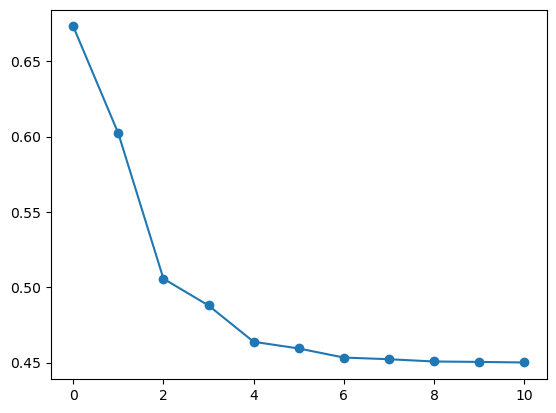

In [14]:
MSP_tree = mixed_state_tree(process, tree_depth=11)
H_mu = block_entropy(MSP_tree)
H_mu_L = myopic_entropy(MSP_tree)

from matplotlib import pyplot as plt

plt.plot(H_mu_L, "o-")
plt.show()

In [18]:

path_probs = collect_path_probs_with_paths(MSP_tree, 11)

seqs = np.array([path[0] for path in path_probs])
probs = np.array([path[1] for path in path_probs])
print(probs.sum())


1.0


In [27]:
belief_states = MSP_tree.get_belief_states()
belief_states = np.array(belief_states)

# Assign a group label to each belief state row based on uniqueness with a tolerance for L2 distance
def assign_labels_to_belief_states(arr, tol=0.01):
    unique = []
    labels = []
    for row in arr:
        distances = np.linalg.norm(np.array(unique) - row, axis=1) if unique else [float('inf')]
        min_dist_idx = np.argmin(distances)
        if distances[min_dist_idx] > tol:  # if the closest distance is greater than tol, it's unique
            unique.append(row)
            labels.append(len(unique) - 1)  # Assign a new label for this unique row
        else:
            labels.append(min_dist_idx)  # Assign the label of the closest existing unique row
    return np.array(labels)

belief_state_labels = assign_labels_to_belief_states(belief_states)
print(f"Number of unique rows with tolerance: {len(np.unique(belief_state_labels))}")
print(f"Belief state labels: {belief_state_labels}")
unique_belief_states = belief_states[belief_state_labels]
unique_labels = np.unique(belief_state_labels)
unique_belief_states = np.zeros((len(unique_labels), 2))
for ul in unique_labels:
    idx = np.where(belief_state_labels == ul)[0][0]
    unique_belief_states[ul] = belief_states[idx]



Number of unique rows with tolerance: 4
Belief state labels: [0 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2 2 1 2 1 1
 2 2 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1
 1 1 2 2 1 2 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2
 2 1 2 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1
 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1
 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2
 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1
 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 1 1
 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 1 1 2 2 1
 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 1 2 2
 1 1 1 2 2 1 3 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2
 2 1 2 1 1 2 2 1 1 1 1 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 1 1 2 2 1 2
 1 1 2 2 1 1 1 2 2 1 2 1 1 1 1 2 2 1 2 

In [28]:
unique_belief_states

array([[0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0.5, 0.5]])